In [1]:
import os
import pandas as pd
from tqdm import tqdm

def read_patch_paths(image_folder, mask_folder):
    image_paths = []
    mask_paths = []

    # Get a list of image patch files in the folder
    image_files = os.listdir(image_folder)

    # Assuming the file names are the same in the mask folder
    for file_name in tqdm(image_files):
        image_path = os.path.join(image_folder, file_name)
        mask_path = os.path.join(mask_folder, file_name)

        # Check if both image and mask paths exist
        if os.path.exists(image_path) and os.path.exists(mask_path):
            image_paths.append(image_path)
            mask_paths.append(mask_path)

    # Create a DataFrame
    df = pd.DataFrame({'Image': image_paths, 'Mask': mask_paths})
    return df

# Specify the paths to the image and mask patch folders
image_patch_folder = "/kaggle/input/training-patches-he-512-idrid/HE_patches - Copy/image_patches_512/"
mask_patch_folder = "/kaggle/input/training-patches-he-512-idrid/HE_patches - Copy/mask_patches_512/"

# Read patch paths and create a DataFrame
df_patches = read_patch_paths(image_patch_folder, mask_patch_folder)

100%|██████████| 1168/1168 [00:04<00:00, 268.94it/s]


In [2]:
df_patches.head()

,Image,Mask
0,/kaggle/input/training-patches-he-512-idrid/HE...,/kaggle/input/training-patches-he-512-idrid/HE...
1,/kaggle/input/training-patches-he-512-idrid/HE...,/kaggle/input/training-patches-he-512-idrid/HE...
2,/kaggle/input/training-patches-he-512-idrid/HE...,/kaggle/input/training-patches-he-512-idrid/HE...
3,/kaggle/input/training-patches-he-512-idrid/HE...,/kaggle/input/training-patches-he-512-idrid/HE...
4,/kaggle/input/training-patches-he-512-idrid/HE...,/kaggle/input/training-patches-he-512-idrid/HE...


In [3]:
import cv2
import numpy as np
import albumentations as A
from tensorflow.keras.utils import Sequence
from sklearn.preprocessing import MinMaxScaler

scaler=MinMaxScaler()
def apply_clahe(image):
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a, b))
    clahe_image = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)
    return clahe_image

class CustomDataGenerator(Sequence):
    def __init__(self, df, batch_size, image_size, shuffle=True):
        self.df = df
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.on_epoch_end()
        self.transform = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            #A.RandomBrightnessContrast(p=0.2),
            #A.Rotate(limit=10, p=0.3)
        ])

    def __len__(self):
        return int(np.ceil(len(self.df) / float(self.batch_size)))

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __getitem__(self, index):
        batch_df = self.df[index * self.batch_size : (index + 1) * self.batch_size]

        images = []
        masks = []

        for i, row in batch_df.iterrows():

            image = cv2.imread(row['Image'], cv2.IMREAD_COLOR)
            image = apply_clahe(image)
            #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, self.image_size)
            #shape = image.shape
            #image = scaler.fit_transform(image.reshape(-1, shape[-1])).reshape(shape)
            image = image/np.max(image)
            #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            mask_path = row['Mask']
            if mask_path:
                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                mask = cv2.resize(mask, self.image_size)
                mask=mask>0
    

            augmented = self.transform(image=image, mask=mask)
            images.append(augmented['image'])
            masks.append(augmented['mask'])
        
                

        #images = np.expand_dims(np.array(images, dtype=np.float32), axis=-1)
        images = np.array(images, dtype=np.float32)
        masks = np.expand_dims(np.array(masks, dtype=np.float32), axis=-1)
        return  images, masks

# Example usage of the CustomDataGenerator
train_generator = CustomDataGenerator(df_patches, batch_size=8, image_size=(256, 256), shuffle=True)


2024-02-01 14:04:08.550000: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-01 14:04:08.550159: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-01 14:04:08.687793: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


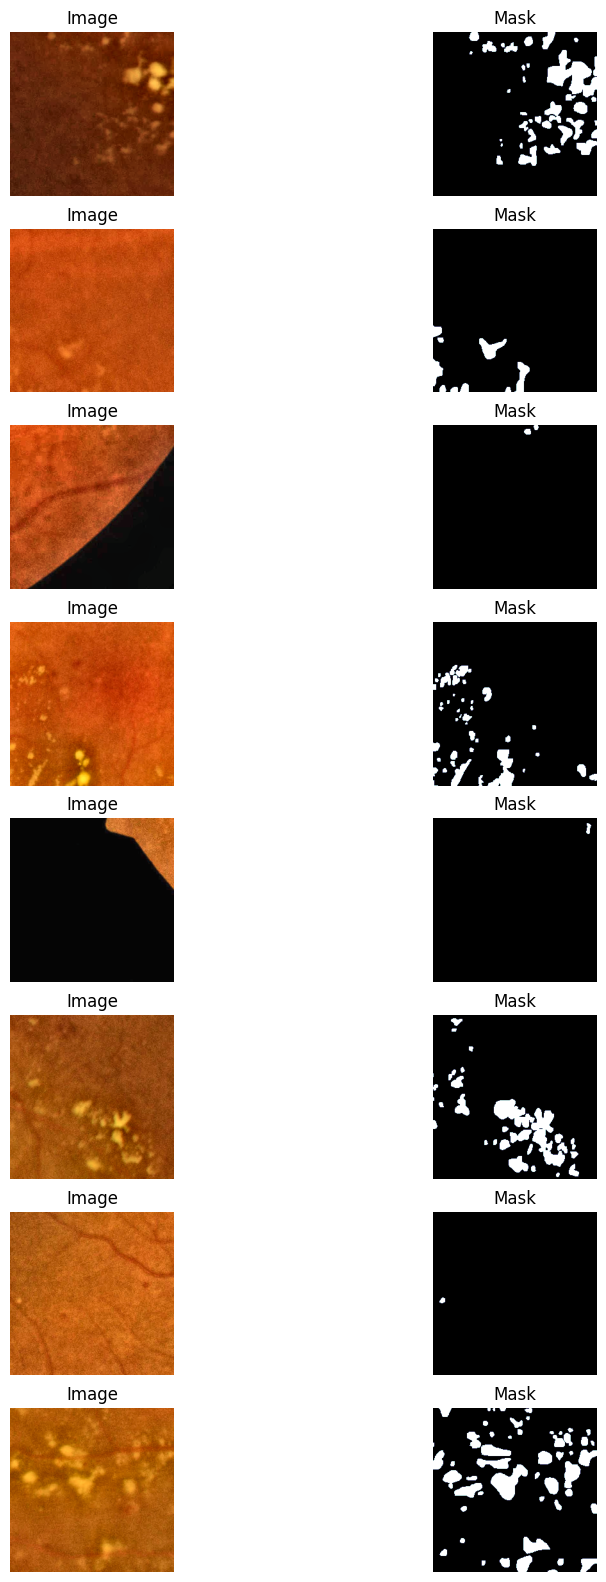

In [4]:
import matplotlib.pyplot as plt

# Load a single batch
batch = train_generator[0]  # Assuming you want to load the first batch

# Extract images and labels from the batch
images, masks = batch

# Display the images and masks
n_images_to_display = len(images)
fig, ax = plt.subplots(n_images_to_display, 2, figsize=(10, 20))
for i in range(n_images_to_display):
    ax[i, 0].imshow(images[i], cmap='bone')
    #print(np.max(images[i]))
    ax[i, 0].set_title('Image')
    ax[i, 1].imshow(masks[i], cmap='bone')
    #print(np.max(masks[i]))
    ax[i, 1].set_title('Mask')

    ax[i, 0].axis('off')
    ax[i, 1].axis('off')
plt.show()


In [5]:
from sklearn.model_selection import train_test_split

df_shuffled = df_patches.sample(frac=1, random_state=42)
train_df, val_df = train_test_split(df_shuffled, test_size=0.2, random_state=42)

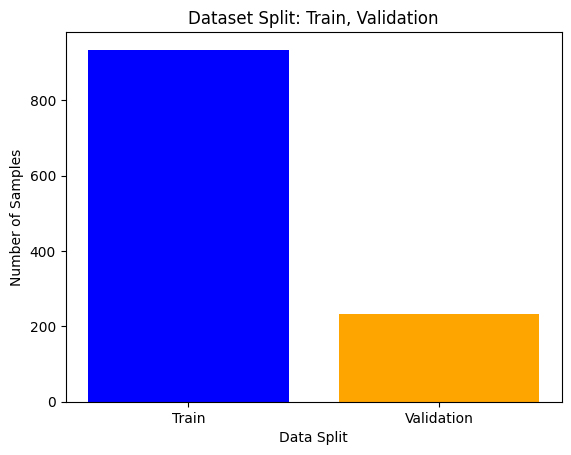

In [6]:
# bar plot
from matplotlib import pyplot as plt
sizes = [len(train_df), len(val_df)]
labels = ['Train', 'Validation']

plt.bar(labels, sizes, color=['blue', 'orange'])
plt.xlabel('Data Split')
plt.ylabel('Number of Samples')
plt.title('Dataset Split: Train, Validation')
plt.show()

# Model Architecture and Helper blocks

In [7]:
#GCSE Block...from the GCSER UNET (Mukherjee et al.)
def GCSE(input_tensor, ratio=16):


    # Compute the global statistics (mean and std deviation) along the channel axis.
    mean = tf.reduce_mean(input_tensor, axis=[1, 2], keepdims=True)
    std = tf.math.reduce_std(input_tensor, axis=[1, 2], keepdims=True)

    # Compute channel-wise attention using a convolutional neural network.
    attn_channel = tf.concat([mean, std], axis=-1)
    attn_channel = tf.keras.layers.Conv2D(filters=input_tensor.shape[-1] // ratio, kernel_size=(1, 1), activation='relu')(attn_channel)
    attn_channel = tf.keras.layers.Conv2D(filters=input_tensor.shape[-1], kernel_size=(1, 1), activation='sigmoid')(attn_channel)

    # Compute spatial attention using global information from the input tensor.
    global_info = tf.reduce_mean(input_tensor, axis=-1, keepdims=True)
    attn_spatial = tf.keras.layers.Conv2D(filters=1, kernel_size=(1, 1), activation='sigmoid')(global_info)

    # Combine channel-wise and spatial attention.
    attn = tf.keras.layers.Multiply()([attn_channel,attn_spatial])

    # Multiply the input tensor by the learned attention weights.
    output_tensor = tf.keras.layers.Multiply()([input_tensor,attn])

    return output_tensor

In [8]:
def ASPP(x, filter):
    shape = x.shape

    y1 = AveragePooling2D(pool_size=(shape[1], shape[2]))(x)
    y1 = Conv2D(filter, 1, padding="same")(y1)
    y1 = BatchNormalization()(y1)
    y1 = Activation("relu")(y1)
    y1 = UpSampling2D((shape[1], shape[2]), interpolation="bilinear")(y1)

    y2 = Conv2D(filter, 1, dilation_rate=1, padding="same", use_bias=False)(x)
    y2 = BatchNormalization()(y2)
    y2 = Activation("relu")(y2)

    y3 = Conv2D(filter, 3, dilation_rate=3, padding="same", use_bias=False)(x)
    y3 = BatchNormalization()(y3)
    y3 = Activation("relu")(y3)

    y4 = Conv2D(filter, 3, dilation_rate=5, padding="same", use_bias=False)(x)
    y4 = BatchNormalization()(y4)
    y4 = Activation("relu")(y4)

    y5 = Conv2D(filter, 3, dilation_rate=7, padding="same", use_bias=False)(x)
    y5 = BatchNormalization()(y5)
    y5 = Activation("relu")(y5)

    y = Concatenate()([y1, y2, y3, y4, y5])

    y = Conv2D(filter, 1, dilation_rate=1, padding="same", use_bias=False)(y)
    y = BatchNormalization()(y)
    y = Activation("relu")(y)

    return y

# Symmetric Architecture

In [9]:
# Code for W-Net
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D,Conv2DTranspose, BatchNormalization, Activation, MaxPool2D, UpSampling2D, Concatenate, Input, ZeroPadding2D,Dropout,Dense,MaxPooling2D,Reshape,Multiply,GlobalAveragePooling2D,AveragePooling2D
from tensorflow.keras.models import Model

def dice_coeff(y_true, y_pred, smooth=1e-5):
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)
    intersection = K.sum(y_true_flatten * y_pred_flatten)
    dice = (2. * intersection + smooth) / (K.sum(y_true_flatten) + K.sum(y_pred_flatten) + smooth)
    return dice
"""def complementary_loss(y_true, y_pred):
    mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))
    return tf.math.sigmoid(mse_loss)"""
"""def complementary_loss(feature_map1,feature_map2):
    # Normalize the feature maps to [0, 1]
    feature_map1 /= tf.reduce_max(feature_map1)
    feature_map2 /= tf.reduce_max(feature_map2)
    m1 = tf.reduce_mean(feature_map1,axis=-1)
    m2  = tf.reduce_mean(feature_map2,axis=-1)
    return (tf.abs(m1-m2))"""

"""def complementary_loss(feature_map1,feature_map2):
    #feature_map1 = tf.reduce_mean(feature_map1, axis=-1, keepdims=True)
    #feature_map2  = tf.reduce_mean(feature_map2, axis=-1, keepdims=True)
    #m1 = tf.reduce_mean(feature_map1)
    #m2 = tf.reduce_mean(feature_map2)
    feature_map1 /= tf.reduce_max(feature_map1)
    feature_map2 /= tf.reduce_max(feature_map2)
    #print(feature_map1.shape) #shapes are (none,H,W,1) so axis = 1 2 3 
    intersection = tf.reduce_sum(feature_map1 * feature_map2, axis=[1, 2, 3])
    union = tf.reduce_sum(feature_map1 + feature_map2, axis=[1, 2, 3]) - intersection
    iou = (intersection + 1e-5) / (union + 1e-5)
    return iou
    return tf.abs(m1-m2) + dice_coeff(feature_map1,feature_map2)"""
def complementary_loss(x1, x2):
    x1 = tf.reduce_mean(x1, axis=-1, keepdims=True)
    x2  = tf.reduce_mean(x2, axis=-1, keepdims=True)
    
    x1_flat = tf.reshape(x1, (tf.shape(x1)[0], -1))
    x2_flat = tf.reshape(x2, (tf.shape(x2)[0], -1))

    # Normalize the feature maps
    x1_normalized = tf.nn.l2_normalize(x1_flat, axis=1)
    x2_normalized = tf.nn.l2_normalize(x2_flat, axis=1)

    # Calculate cosine similarity
    cosine_similarity = tf.reduce_sum(x1_normalized * x2_normalized, axis=1)

    # Take the mean across the batch
    #loss = 1.0 - tf.reduce_mean(cosine_similarity)

    return cosine_similarity
    
clipping_layer = tf.keras.layers.Lambda(
    lambda x: tf.clip_by_value(x , clip_value_min=-1, clip_value_max=1),
    name='output_2'
)

def batchnorm_relu(inputs):
    x = BatchNormalization()(inputs)
    #x = Activation("relu")(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    return x

def residual_block(inputs, num_filters):
    """ Convolutional Layer """
    x = batchnorm_relu(inputs)
    x = Conv2D(num_filters, 3, padding="same", strides=1,kernel_initializer = "he_normal")(x)
    x = Dropout(0.1)(x)
    x = batchnorm_relu(x)
    x = Conv2D(num_filters, 3, padding="same", strides=1,kernel_initializer = "he_normal")(x)


    """ Shortcut Connection """
    s = Conv2D(num_filters, 1, padding="same", strides=1,kernel_initializer="he_normal")(inputs)
    x = x + s
    return x

def decoder_block(inputs, s1,s2, num_filters):
    x = Conv2DTranspose(num_filters,2, strides=(2,2), kernel_initializer="he_normal",padding = "same")(inputs)
    x = Concatenate()([x,s1,s2])
    x = residual_block(x, num_filters)
    x = GCSE(x)
    return x
def build_encoder(inputs,f,name):
    
    x = Conv2D(f[0], 3, padding="same", strides=1,kernel_initializer="he_normal")(inputs)
    x = batchnorm_relu(x)
    x = Conv2D(f[0], 3, padding="same", strides=1,kernel_initializer="he_normal")(x)
    s = Conv2D(f[0], 1, padding="same", strides=1,kernel_initializer="he_normal")(inputs)

    c1 = x + s
    c1 = GCSE(c1)
    p1 = MaxPooling2D((2,2))(c1)
    s1 = c1

    c2 = residual_block(p1, f[1])
    c2 = GCSE(c2)
    p2 = MaxPooling2D((2,2))(c2)
    s2 = c2

    c3 = residual_block(p2, f[2])
    c3 = GCSE(c3)
    p3 = MaxPooling2D((2,2))(c3)
    s3 = c3

    c4 = residual_block(p3, f[3])
    c4 = GCSE(c4)
    p4 = MaxPooling2D((2,2))(c4)
    s4 = c4
    
    s_ = [s1,s2,s3,s4]
    """ Bridge """
    b = ASPP(p4,128)
    encoder1 = Model(inputs,outputs=[s_,b],name=name)
    return encoder1

    
    

def build_WNet(input_shape):
    f = [32,64,128,256]

    inputs = Input(input_shape,name="model_input")
    encoder1 = build_encoder(inputs,f,name="encoder1")
    encoder2 = build_encoder(inputs,f,name="encoder2")
    s1,b1 = encoder1(inputs)
    s2,b2 = encoder2(inputs)

    b = Concatenate()([b1,b2])

    """ Decoder 1, 2, 3 """
    d1 = decoder_block(b, s2[3],s1[3], f[3])
    d2 = decoder_block(d1, s2[2],s1[2], f[2])
    d3 = decoder_block(d2, s2[1],s1[1], f[1])
    d4 = decoder_block(d3, s2[0],s1[0],f[0])
    
    comp1 = complementary_loss(s2[0], s1[0])
    comp2 = complementary_loss(s2[1], s1[1])
    comp3 = complementary_loss(s2[2], s1[2])
    comp4 = complementary_loss(s2[3], s1[3])
    
    #output_2 = (comp1+comp2+comp3+comp4)/4.0
    output_2 = tf.keras.layers.Add(name='output_2_sum')([comp1/4.0,comp2/4.0,comp3/4.0,comp4/4.0])
    output_2 = clipping_layer(output_2)

    """ Classifier """
    output_1 = Conv2D(1, (1,1) , activation="sigmoid",name='output_1')(d4)

    """ Model """
    model = Model(inputs,outputs=[output_1,output_2])
    return model

# Evaluation Metrics

In [10]:
from keras import backend as K
import tensorflow as tf
epsilon = 1e-5
smooth = 1e-5

def dice_coeff(y_true, y_pred, smooth=1e-5):
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)
    intersection = K.sum(y_true_flatten * y_pred_flatten)
    dice = (2. * intersection + smooth) / (K.sum(y_true_flatten) + K.sum(y_pred_flatten) + smooth)
    return dice

def dice_loss(y_true, y_pred):
    return  1- dice_coeff(y_true, y_pred, smooth=1e-5)

def FocalLoss(targets, inputs, alpha=0.25, gamma=2):    
    
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)
    
    BCE = K.binary_crossentropy(targets, inputs)
    BCE_EXP = K.exp(-BCE)
    focal_loss = K.mean(alpha * K.pow((1-BCE_EXP), gamma) * BCE)
    
    return focal_loss

def total_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    return dice_loss(y_true, y_pred) + FocalLoss(y_true, y_pred, 0.25,2)
def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

def iou_score(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true + y_pred, axis=[1, 2, 3]) - intersection
    iou = (intersection + 1e-5) / (union + 1e-5)
    return iou


In [11]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from keras.callbacks import CSVLogger
model = build_WNet((256,256,3))

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 model_input (InputLayer)    [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 encoder1 (Functional)       [[(None, 256, 256, 32),      2270886   ['model_input[0][0]']         
                              (None, 128, 128, 64),                                               
                              (None, 64, 64, 128),                                                
                              (None, 32, 32, 256)],                                               
                              (None, 16, 16, 128)]                                                
                                                                                              

In [13]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001), loss={'output_1':total_loss, 'output_2':lambda y_true, y_pred: y_pred},
              loss_weights = {'output_1':1, 'output_2':0},
              metrics = {"output_1":[iou_score,dice_coeff,tf.keras.metrics.Precision(),
    tf.keras.metrics.Recall(),sensitivity,specificity,tf.keras.metrics.AUC()]})

#callbacks
csv_logger = CSVLogger('/kaggle/working/training_log_WCE_segmentation', separator=',', append=True)
earlystopping = EarlyStopping(monitor='val_output_1_loss',
                              mode='min', 
                              verbose=1, 
                              patience=9
                             )
# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="/kaggle/working/WNet_maxpool.h5", 
                               monitor="val_output_1_loss",
                               verbose=1, 
                               save_best_only=True,
                               save_weights_only=True
                              )

reduce_lr = ReduceLROnPlateau(monitor='val_output_1_loss', factor=0.3, patience=4, min_lr=1e-6, verbose=1)
                              
"""reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=4,
                              min_delta=0.000001,
                              factor=0.3
                             )"""
callbacks = [checkpointer, earlystopping, reduce_lr, csv_logger]

# Iterative Training Scheme
# Two losses are used: 
* for segmentation: $Dice Loss + Focal Loss$
* $Complementary~Loss$: to ensure that both models do not learn the same features

In [14]:
from keras import backend as K

batch_size = 4
N = 256
train_generator = CustomDataGenerator(train_df, batch_size=batch_size, image_size=(N,N), shuffle=True)
val_generator = CustomDataGenerator(val_df, batch_size=batch_size, image_size=(N,N), shuffle=False)
num_epochs = 50
lr_reduction_factor = 0.5
lr_reduction_patience = 4  # Set the patience for validation loss reduction
early_stopping_patience = 9
best_val_loss = float('inf')  # Initialize the best validation loss
no_improvement_counter = 0
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")

    # Set the training status for encoder1 and encoder2
    if epoch % 2 == 0:
        model.get_layer('encoder1').trainable = True
        model.get_layer('encoder2').trainable = False
    else:
        model.get_layer('encoder1').trainable = False
        model.get_layer('encoder2').trainable = True

    # Train the model for one epoch
    history = model.fit(train_generator, steps_per_epoch=len(train_df) // batch_size,
                    validation_data=val_generator, validation_steps=len(val_df) // batch_size,
                    epochs=1,callbacks=callbacks)
    
    val_loss = history.history['val_output_1_loss'][-1]
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improvement_counter = 0
    else:
        no_improvement_counter += 1

        # Apply learning rate reduction if validation loss does not improve for patience epochs
        if no_improvement_counter >= lr_reduction_patience:
            current_learning_rate = K.get_value(model.optimizer.learning_rate)
            new_learning_rate = current_learning_rate * lr_reduction_factor
            K.set_value(model.optimizer.learning_rate, new_learning_rate)
            #no_improvement_counter = 0
            
        if no_improvement_counter >= early_stopping_patience:
            print("Early stopping due to no improvement in validation loss.")
            break

# Save the final trained model
model.save_weights('./final_model.h5')

Epoch 1/50


2024-02-01 14:04:46.619091: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/encoder1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1706796294.836837      74 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


233/233 [==============================] - ETA: 0s - loss: 0.5504 - output_1_loss: 0.5504 - output_2_loss: 0.0678 - output_1_iou_score: 0.2546 - output_1_dice_coeff: 0.4824 - output_1_precision: 0.5316 - output_1_recall: 0.5253 - output_1_sensitivity: 0.5441 - output_1_specificity: 0.9863 - output_1_auc: 0.8395
Epoch 1: val_output_1_loss improved from inf to 1.08348, saving model to /kaggle/working/WNet_maxpool.h5
233/233 [==============================] - 103s 236ms/step - loss: 0.5504 - output_1_loss: 0.5504 - output_2_loss: 0.0678 - output_1_iou_score: 0.2546 - output_1_dice_coeff: 0.4824 - output_1_precision: 0.5316 - output_1_recall: 0.5253 - output_1_sensitivity: 0.5441 - output_1_specificity: 0.9863 - output_1_auc: 0.8395 - val_loss: 1.0835 - val_output_1_loss: 1.0835 - val_output_2_loss: -0.2169 - val_output_1_iou_score: 1.3798e-04 - val_output_1_dice_coeff: 3.8999e-04 - val_output_1_precision: 0.9167 - val_output_1_recall: 1.3353e-04 - val_output_1_sensitivity: 7.1940e-05 - va

In [15]:
history.history.keys()

dict_keys(['loss', 'output_1_loss', 'output_2_loss', 'output_1_iou_score', 'output_1_dice_coeff', 'output_1_precision', 'output_1_recall', 'output_1_sensitivity', 'output_1_specificity', 'output_1_auc', 'val_loss', 'val_output_1_loss', 'val_output_2_loss', 'val_output_1_iou_score', 'val_output_1_dice_coeff', 'val_output_1_precision', 'val_output_1_recall', 'val_output_1_sensitivity', 'val_output_1_specificity', 'val_output_1_auc', 'lr'])

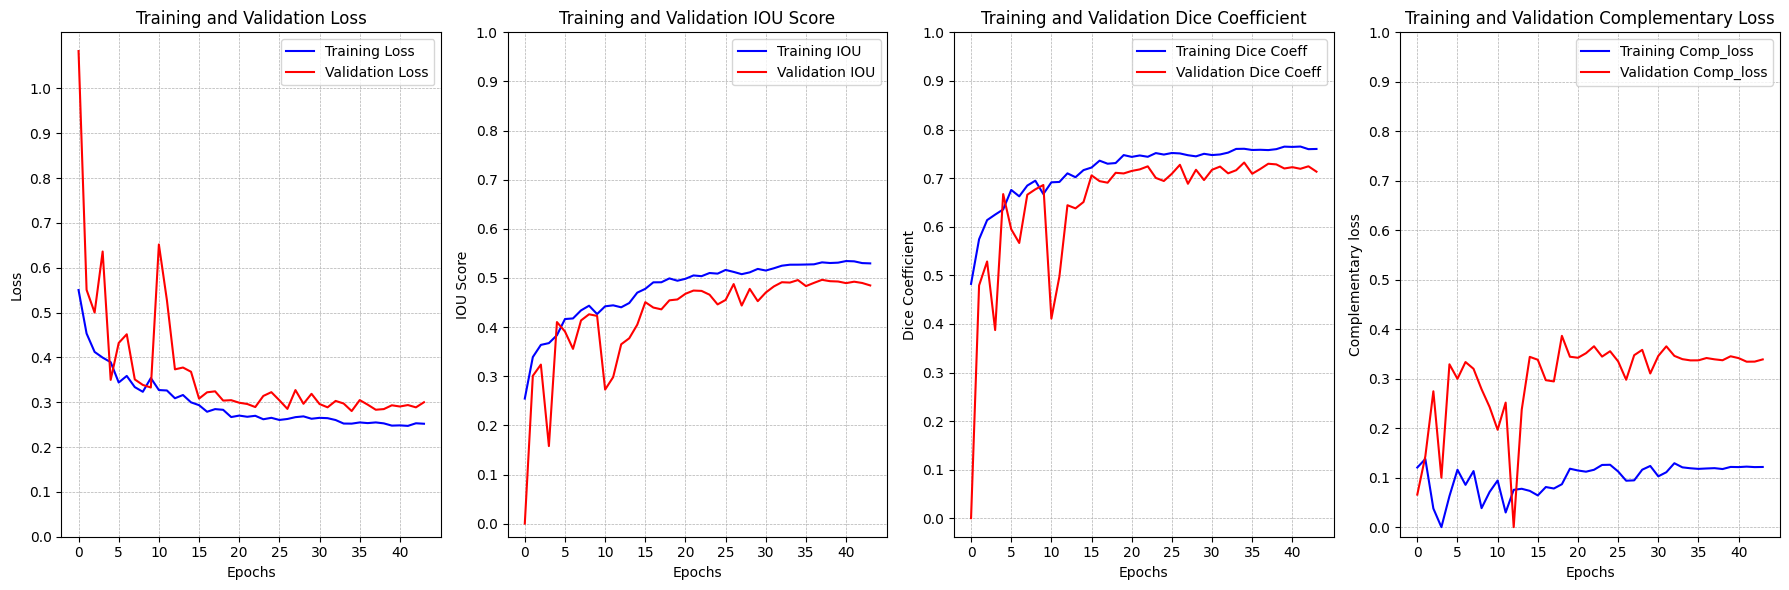

In [16]:
from matplotlib import pyplot as plt
history = pd.read_csv('/kaggle/working/training_log_WCE_segmentation', sep=',', engine='python')

#history= history

############### ########## ####### #######

iou_score=history['output_1_iou_score']
val_iou_score=history['val_output_1_iou_score']

loss=history['output_1_loss']
val_loss=history['val_output_1_loss']

train_dice=history['output_1_dice_coeff']
val_dice=history['val_output_1_dice_coeff']

train_cl = history['output_2_loss']
train_cl = train_cl-np.min(train_cl)
val_cl = history['val_output_2_loss']
val_cl = val_cl-np.min(val_cl)

epoch = np.arange(len(loss))

# Create subplots
fig, axes = plt.subplots(1, 4, figsize=(18, 6))
plt.subplots_adjust(wspace=0.3)  # Adjust the space between subplots

# Plot 1: Loss
axes[0].plot(epoch, loss, 'b', label='Training Loss', linewidth=1.5)
axes[0].plot(epoch, val_loss, 'r', label='Validation Loss', linewidth=1.5)
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()

# Plot 2: IOU Scores
axes[1].plot(epoch, iou_score, 'b', label='Training IOU', linewidth=1.5)
axes[1].plot(epoch, val_iou_score, 'r', label='Validation IOU', linewidth=1.5)
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('IOU Score')
axes[1].set_title('Training and Validation IOU Score')
axes[1].legend()

# Plot 3: Dice Coefficients
axes[2].plot(epoch, train_dice, 'b', label='Training Dice Coeff', linewidth=1.5)
axes[2].plot(epoch, val_dice, 'r', label='Validation Dice Coeff', linewidth=1.5)
axes[2].set_xlabel('Epochs')
axes[2].set_ylabel('Dice Coefficient')
axes[2].set_title('Training and Validation Dice Coefficient')
axes[2].legend()

# Plot 3: Dice Coefficients
axes[3].plot(epoch, train_cl, 'b', label='Training Comp_loss', linewidth=1.5)
axes[3].plot(epoch, val_cl, 'r', label='Validation Comp_loss', linewidth=1.5)
axes[3].set_xlabel('Epochs')
axes[3].set_ylabel('Complementary loss')
axes[3].set_title('Training and Validation Complementary Loss')
axes[3].legend()

# Customize tick marks and labels
for ax in axes:
    ax.grid(True)
    ax.set_xticks(np.arange(0, len(epoch), 5))  # Adjust the x-axis ticks
    ax.set_yticks(np.arange(0, 1.1, 0.1))  # Adjust the y-axis ticks
    ax.grid(which='both', linestyle='--', linewidth=0.5)

# Display the plots
plt.tight_layout()
plt.show()

# Fine-tuning Joint updation

In [17]:
"""from tensorflow.keras.models import load_model

custom_objects = {'total_loss': total_loss,
                  '<lambda>': lambda y_true, y_pred: y_pred,
                  'iou_score':iou_score,
                  'dice_coeff':dice_coeff,
                  'precision':tf.keras.metrics.Precision(),
                  'recall':tf.keras.metrics.Recall(),
                  'sensitivity':sensitivity,
                  'specificity':specificity
                 }

with tf.keras.utils.custom_object_scope(custom_objects):
    model = load_model('/kaggle/working/final_model.h5')"""

"from tensorflow.keras.models import load_model\n\ncustom_objects = {'total_loss': total_loss,\n                  '<lambda>': lambda y_true, y_pred: y_pred,\n                  'iou_score':iou_score,\n                  'dice_coeff':dice_coeff,\n                  'precision':tf.keras.metrics.Precision(),\n                  'recall':tf.keras.metrics.Recall(),\n                  'sensitivity':sensitivity,\n                  'specificity':specificity\n                 }\n\nwith tf.keras.utils.custom_object_scope(custom_objects):\n    model = load_model('/kaggle/working/final_model.h5')"

Im going for this method instead...more efficient

In [18]:
model = build_WNet((256,256,3))

In [19]:
from keras import backend as K
import tensorflow as tf
epsilon = 1e-5
smooth = 1e-5

def dice_coeff(y_true, y_pred, smooth=1e-5):
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)
    intersection = K.sum(y_true_flatten * y_pred_flatten)
    dice = (2. * intersection + smooth) / (K.sum(y_true_flatten) + K.sum(y_pred_flatten) + smooth)
    return dice

def dice_loss(y_true, y_pred):
    return  1- dice_coeff(y_true, y_pred, smooth=1e-5)

def FocalLoss(targets, inputs, alpha=0.25, gamma=2):    
    
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)
    
    BCE = K.binary_crossentropy(targets, inputs)
    BCE_EXP = K.exp(-BCE)
    focal_loss = K.mean(alpha * K.pow((1-BCE_EXP), gamma) * BCE)
    
    return focal_loss

def total_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    return dice_loss(y_true, y_pred) + FocalLoss(y_true, y_pred, 0.25,2)
def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

def iou_score(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true + y_pred, axis=[1, 2, 3]) - intersection
    iou = (intersection + 1e-5) / (union + 1e-5)
    return iou


In [20]:
model.load_weights("/kaggle/working/WNet_maxpool.h5")
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.00001), loss={'output_1':total_loss, 'output_2':lambda y_true, y_pred: y_pred},
              loss_weights = {'output_1':1, 'output_2':0},
              metrics = {"output_1":[iou_score,dice_coeff,tf.keras.metrics.Precision(),
    tf.keras.metrics.Recall(),sensitivity,specificity,tf.keras.metrics.AUC()]})


In [21]:
model.get_layer("encoder1").trainable = True
model.get_layer("encoder2").trainable = True

In [22]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from keras.callbacks import CSVLogger
csv_logger = CSVLogger('/kaggle/working/training_log_WCE_segmentation', separator=',', append=True)
earlystopping = EarlyStopping(monitor='val_output_1_loss',
                              mode='min', 
                              verbose=1, 
                              patience=3
                             )
# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="/kaggle/working/WNet_maxpool_fine_tuned.h5",
                               monitor='val_output_1_loss',
                               verbose=1, 
                               save_best_only=True,
                               save_weights_only=True
                              )

reduce_lr = ReduceLROnPlateau(monitor='val_output_1_loss', factor=0.3, patience=2, min_lr=1e-7, verbose=1)
                              
"""reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=4,
                              min_delta=0.000001,
                              factor=0.3
                             )"""
callbacks = [checkpointer, reduce_lr, csv_logger, earlystopping]

In [23]:
batch_size = 4
N = 256
train_generator = CustomDataGenerator(train_df, batch_size=batch_size, image_size=(N,N), shuffle=True)
val_generator = CustomDataGenerator(val_df, batch_size=batch_size, image_size=(N,N), shuffle=False)
history_ = model.fit(train_generator, steps_per_epoch=len(train_df) // batch_size,
                    validation_data=val_generator, validation_steps=len(val_df) // batch_size,
                    epochs=10,callbacks=callbacks)

Epoch 1/10


2024-02-01 14:38:35.487482: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/encoder1/dropout_10/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


233/233 [==============================] - ETA: 0s - loss: 0.2489 - output_1_loss: 0.2489 - output_2_loss: 0.0647 - output_1_iou_score: 0.5278 - output_1_dice_coeff: 0.7638 - output_1_precision_1: 0.8295 - output_1_recall_1: 0.8021 - output_1_sensitivity: 0.7671 - output_1_specificity: 0.9950 - output_1_auc_1: 0.9466
Epoch 1: val_output_1_loss improved from inf to 0.28719, saving model to /kaggle/working/WNet_maxpool_fine_tuned.h5
233/233 [==============================] - 83s 199ms/step - loss: 0.2489 - output_1_loss: 0.2489 - output_2_loss: 0.0647 - output_1_iou_score: 0.5278 - output_1_dice_coeff: 0.7638 - output_1_precision_1: 0.8295 - output_1_recall_1: 0.8021 - output_1_sensitivity: 0.7671 - output_1_specificity: 0.9950 - output_1_auc_1: 0.9466 - val_loss: 0.2872 - val_output_1_loss: 0.2872 - val_output_2_loss: 0.0565 - val_output_1_iou_score: 0.4850 - val_output_1_dice_coeff: 0.7261 - val_output_1_precision_1: 0.7401 - val_output_1_recall_1: 0.8685 - val_output_1_sensitivity: 0.

In [24]:
# Save the final trained model
"model.save('final_model_fine_tuned.h5')"

"model.save('final_model_fine_tuned.h5')"

In [25]:
model.save_weights('./final_model_fine_tuned.h5')

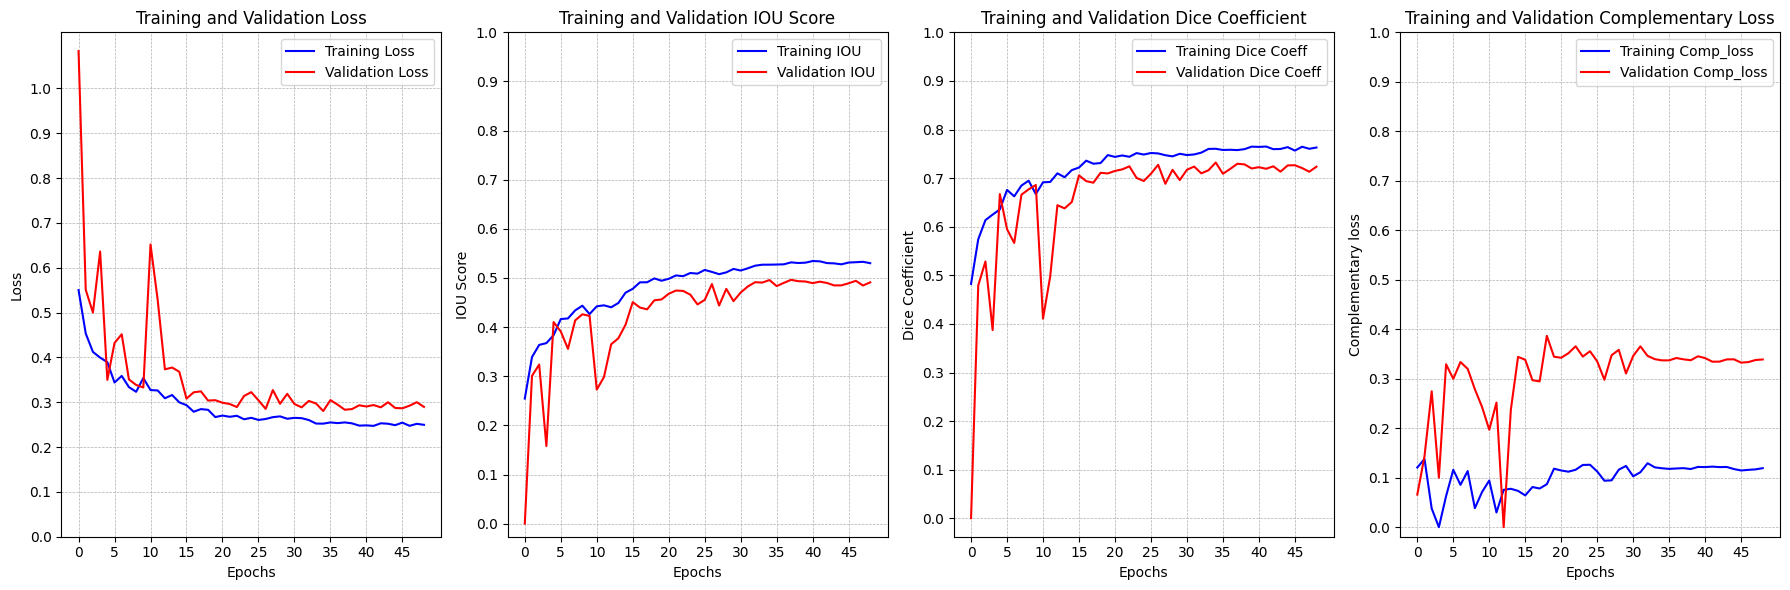

In [26]:
from matplotlib import pyplot as plt
history = pd.read_csv('/kaggle/working/training_log_WCE_segmentation', sep=',', engine='python')

#history= history

############### ########## ####### #######

iou_score=history['output_1_iou_score']
val_iou_score=history['val_output_1_iou_score']

loss=history['output_1_loss']
val_loss=history['val_output_1_loss']

train_dice=history['output_1_dice_coeff']
val_dice=history['val_output_1_dice_coeff']

train_cl = history['output_2_loss']
train_cl = train_cl-np.min(train_cl)
val_cl = history['val_output_2_loss']
val_cl = val_cl-np.min(val_cl)

epoch = np.arange(len(loss))

# Create subplots
fig, axes = plt.subplots(1, 4, figsize=(18, 6))
plt.subplots_adjust(wspace=0.3)  # Adjust the space between subplots

# Plot 1: Loss
axes[0].plot(epoch, loss, 'b', label='Training Loss', linewidth=1.5)
axes[0].plot(epoch, val_loss, 'r', label='Validation Loss', linewidth=1.5)
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()

# Plot 2: IOU Scores
axes[1].plot(epoch, iou_score, 'b', label='Training IOU', linewidth=1.5)
axes[1].plot(epoch, val_iou_score, 'r', label='Validation IOU', linewidth=1.5)
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('IOU Score')
axes[1].set_title('Training and Validation IOU Score')
axes[1].legend()

# Plot 3: Dice Coefficients
axes[2].plot(epoch, train_dice, 'b', label='Training Dice Coeff', linewidth=1.5)
axes[2].plot(epoch, val_dice, 'r', label='Validation Dice Coeff', linewidth=1.5)
axes[2].set_xlabel('Epochs')
axes[2].set_ylabel('Dice Coefficient')
axes[2].set_title('Training and Validation Dice Coefficient')
axes[2].legend()

# Plot 3: Dice Coefficients
axes[3].plot(epoch, train_cl, 'b', label='Training Comp_loss', linewidth=1.5)
axes[3].plot(epoch, val_cl, 'r', label='Validation Comp_loss', linewidth=1.5)
axes[3].set_xlabel('Epochs')
axes[3].set_ylabel('Complementary loss')
axes[3].set_title('Training and Validation Complementary Loss')
axes[3].legend()

# Customize tick marks and labels
for ax in axes:
    ax.grid(True)
    ax.set_xticks(np.arange(0, len(epoch), 5))  # Adjust the x-axis ticks
    ax.set_yticks(np.arange(0, 1.1, 0.1))  # Adjust the y-axis ticks
    ax.grid(which='both', linestyle='--', linewidth=0.5)

# Display the plots
plt.tight_layout()
plt.show()

# Preparing Testing Data

In [27]:
import os
import pandas as pd
from tqdm import tqdm

def read_patch_paths(image_folder, mask_folder):
    image_paths = []
    mask_paths = []

    # Get a list of image patch files in the folder
    image_files = os.listdir(image_folder)

    # Assuming the file names are the same in the mask folder
    for file_name in tqdm(image_files):
        image_path = os.path.join(image_folder, file_name)
        mask_path = os.path.join(mask_folder, file_name)

        # Check if both image and mask paths exist
        if os.path.exists(image_path) and os.path.exists(mask_path):
            image_paths.append(image_path)
            mask_paths.append(mask_path)

    # Create a DataFrame
    df = pd.DataFrame({'Image': image_paths, 'Mask': mask_paths})
    return df

# Specify the paths to the image and mask patch folders
image_patch_folder = "/kaggle/input/testing-patches-he-512-idrid/HE_patches_test/image_patches_512_no_overlap"
mask_patch_folder = "/kaggle/input/testing-patches-he-512-idrid/HE_patches_test/mask_patches_512_no_overlap"

# Read patch paths and create a DataFrame
df_patches_test = read_patch_paths(image_patch_folder, mask_patch_folder)

100%|██████████| 456/456 [00:01<00:00, 390.58it/s]


In [28]:

import cv2
import numpy as np
import albumentations as A
from tensorflow.keras.utils import Sequence
from sklearn.preprocessing import MinMaxScaler

scaler=MinMaxScaler()
def apply_clahe(image):
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a, b))
    clahe_image = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)
    return clahe_image

class CustomDataGenerator(Sequence):
    def __init__(self, df, batch_size, image_size, shuffle=True):
        self.df = df
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.on_epoch_end()
        self.transform = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            #A.RandomBrightnessContrast(p=0.2),
            #A.Rotate(limit=10, p=0.3)
        ])

    def __len__(self):
        return int(np.ceil(len(self.df) / float(self.batch_size)))

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __getitem__(self, index):
        batch_df = self.df[index * self.batch_size : (index + 1) * self.batch_size]

        images = []
        masks = []

        for i, row in batch_df.iterrows():

            image = cv2.imread(row['Image'], cv2.IMREAD_COLOR)
            image = apply_clahe(image)
            #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, self.image_size)
            #shape = image.shape
            #image = scaler.fit_transform(image.reshape(-1, shape[-1])).reshape(shape)
            image = image/np.max(image)
            #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            mask_path = row['Mask']
            if mask_path:
                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                mask = cv2.resize(mask, self.image_size)
                mask=mask>0
    

            #augmented = self.transform(image=image, mask=mask)
            #images.append(augmented['image'])
            #masks.append(augmented['mask'])
            images.append(image)
            masks.append(mask)
        
                

        #images = np.expand_dims(np.array(images, dtype=np.float32), axis=-1)
        images = np.array(images, dtype=np.float32)
        masks = np.expand_dims(np.array(masks, dtype=np.float32), axis=-1)
        return  images, masks

# Example usage of the CustomDataGenerator
test_generator = CustomDataGenerator(df_patches_test, batch_size=32, image_size=(256, 256), shuffle=False)

In [29]:
model = build_WNet((256,256,3))

In [30]:
from keras import backend as K
import tensorflow as tf
epsilon = 1e-5
smooth = 1e-5

def dice_coeff(y_true, y_pred, smooth=1e-5):
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)
    intersection = K.sum(y_true_flatten * y_pred_flatten)
    dice = (2. * intersection + smooth) / (K.sum(y_true_flatten) + K.sum(y_pred_flatten) + smooth)
    return dice

def dice_loss(y_true, y_pred):
    return  1- dice_coeff(y_true, y_pred, smooth=1e-5)

def FocalLoss(targets, inputs, alpha=0.25, gamma=2):    
    
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)
    
    BCE = K.binary_crossentropy(targets, inputs)
    BCE_EXP = K.exp(-BCE)
    focal_loss = K.mean(alpha * K.pow((1-BCE_EXP), gamma) * BCE)
    
    return focal_loss

def total_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    return dice_loss(y_true, y_pred) + FocalLoss(y_true, y_pred, 0.25,2)
def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

def iou_score(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true + y_pred, axis=[1, 2, 3]) - intersection
    iou = (intersection + 1e-5) / (union + 1e-5)
    return iou

In [31]:
model.load_weights("/kaggle/working/WNet_maxpool.h5")
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001), loss={'output_1':total_loss, 'output_2':lambda y_true, y_pred: y_pred},
              loss_weights = {'output_1':1, 'output_2':0.01},
              metrics = {"output_1":[iou_score,dice_coeff,tf.keras.metrics.Precision(),
    tf.keras.metrics.Recall(),sensitivity,specificity,tf.keras.metrics.AUC()]})

In [32]:
results = model.evaluate(test_generator)

15/15 [==============================] - 25s 916ms/step - loss: 0.2722 - output_1_loss: 0.2715 - output_2_loss: 0.0719 - output_1_iou_score: 0.4998 - output_1_dice_coeff: 0.7493 - output_1_precision_2: 0.6531 - output_1_recall_2: 0.8653 - output_1_sensitivity: 0.8615 - output_1_specificity: 0.9849 - output_1_auc_2: 0.9643


In [33]:
#!zip -r weights_WNet_Res50_AT_CL.zip /kaggle/working/WNet_maxpool.h5

In [34]:
#from IPython.display import FileLink
#FileLink(r'weights_WNet_Res50_AT_CL.zip')